# 0. Imports 

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from os import listdir
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from boruta import BorutaPy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import statsmodels.api as sm

## 0.1 Helper Functions 

In [2]:
def check_last_match(df):
    """
    This function checks if a team won the last match and how many gols each team scored
    """
    seasons = df['data'].dt.year.unique()
    df_result = pd.DataFrame()
    for season in seasons:
        df_season = df[df['data'].dt.year == season]        
        for round_n in range(1, max(df_season.rodada) + 1):
            df_round_n = df_season[df_season['rodada'] == round_n]
            for idx in df_round_n.ID.values:                
                home = df.loc[idx, 'mandante']
                away = df.loc[idx, 'visitante'] 
                if round_n > 1:
                    # win ?
                    if ((df_season['rodada'] == round_n -1) & (df_season['vencedor'] == home)).any():
                        df_season.loc[idx, 'mandante_venceu_ultima'] = 1.0
                    else:
                        df_season.loc[idx, 'mandante_venceu_ultima'] = 0.
                        
                    if ((df_season['rodada'] == round_n -1) & (df_season['vencedor'] == away)).any():
                        df_season.loc[idx, 'visitante_venceu_ultima'] = 1.0                    
                    else:                     
                        df_season.loc[idx, 'visitante_venceu_ultima'] = 0.
                        
                    # n. of goals
                    if ((df_season['rodada'] == round_n-1) & (df_season['mandante'] == home)).any():
                        df_season.loc[idx, 'n_gols_mandante_ultima'] = df_season[((df_season['rodada'] == round_n-1) & (df_season['mandante'] == home))]['mandante_placar'].values[0]
                        
                    elif ((df_season['rodada'] == round_n-1) & (df_season['visitante'] == home)).any():
                        df_season.loc[idx, 'n_gols_mandante_ultima'] = df_season[((df_season['rodada'] == round_n-1) & (df_season['visitante'] == home))]['visitante_placar'].values[0]
                    
                    if ((df_season['rodada'] == round_n-1) & (df_season['mandante'] == away)).any():
                        df_season.loc[idx, 'n_gols_visitante_ultima'] = df_season[((df_season['rodada'] == round_n-1) & (df_season['mandante'] == away))]['mandante_placar'].values[0]
                        
                    elif ((df_season['rodada'] == round_n-1) & (df_season['visitante'] == away)).any():
                        df_season.loc[idx, 'n_gols_visitante_ultima'] = df_season[((df_season['rodada'] == round_n-1) & (df_season['visitante'] == away))]['visitante_placar'].values[0]
               
                else:                 
                    df_season['mandante_venceu_ultima'] = 0
                    df_season['visitante_venceu_ultima'] = 0
                    df_season['n_gols_mandante_ultima'] = 0
                    df_season['n_gols_visitante_ultima'] = 0
                    
        df_result = pd.concat([df_result, df_season], axis = 0)
    return df_result


def add_attributes(df_stats_recent, df_full_recent):
    """
    This function add some attributes from two differente df
    """
    df_full_stats_recent = df_full_recent.copy()
    columns = df_stats_recent.columns.to_list()[4:-1]
           
    for row in range(len(df_full_stats_recent)):
        for column in columns:
            if (df_stats_recent['ID'] == df_full_stats_recent.loc[row, 'ID']).any() & (df_stats_recent['clube'] == df_full_stats_recent.loc[row, 'mandante']).any():
                df_full_stats_recent.loc[row, 'mandante_' + column] = df_stats_recent[(df_stats_recent['ID'] == df_full_stats_recent.loc[row, 'ID']) & (df_stats_recent['clube'] == df_full_stats_recent.loc[row, 'mandante'])][column].values[0]
            else:
                df_full_stats_recent.loc[row, 'mandante_' + column] = np.nan
                
            if (df_stats_recent['ID'] == df_full_stats_recent.loc[row, 'ID']).any() & (df_stats_recent['clube'] == df_full_stats_recent.loc[row, 'visitante']).any():       
                df_full_stats_recent.loc[row, 'visitante_' + column] = df_stats_recent[(df_stats_recent['ID'] == df_full_stats_recent.loc[row, 'ID']) & (df_stats_recent['clube'] == df_full_stats_recent.loc[row, 'visitante'])][column].values[0]
            else:
                df_full_stats_recent.loc[row, 'visitante_' + column] = np.nan    

    return df_full_stats_recent

def create_target(df):
    
    for i in range(0, len(df)):
        if df.loc[i, 'vencedor'] == df.loc[i, 'mandante']:
            df.loc[i, 'resultado'] = 1
        elif df.loc[i, 'vencedor'] == df.loc[i, 'visitante']:
            df.loc[i, 'resultado'] = 2
        else:
            df.loc[i, 'resultado'] = 0  
            
    df = df.drop('vencedor', axis = 1)
            
    return df

# 1. Loading Data 

In [3]:
data_path = '../datasets/'
files = listdir(data_path)

In [4]:
files

['campeonato-brasileiro-cartoes.csv',
 'campeonato-brasileiro-full.csv',
 'campeonato-brasileiro-estatisticas-full.csv',
 'campeonato-brasileiro-gols.csv',
 'Legenda.txt']

In [5]:
cards = files[0]
full = files[1]
stats = files[2]
goals = files[3]

## 1.1 Cards

In [6]:
df_cards = pd.read_csv(data_path + cards)
df_cards.head()

,partida_id,rodada,clube,cartao,atleta,num_camisa,posicao,minuto
0,4607,1,Figueirense,Amarelo,Thiago Heleno,4.0,Zagueiro,44
1,4607,1,Figueirense,Amarelo,Paulo Roberto da Silva,28.0,NaN,66
2,4608,1,Internacional,Amarelo,Juan Silveira dos Santos,4.0,Zagueiro,20
3,4608,1,Vitoria,Amarelo,Vinícius Santos Silva,NaN,NaN,82
4,4608,1,Internacional,Amarelo,Andrés D'Alessandro,10.0,Meio-campo,72


In [7]:
df_cards.isna().sum() / df_cards.shape[0]

partida_id    0.000000
rodada        0.000000
clube         0.000000
cartao        0.000000
atleta        0.000406
num_camisa    0.026138
posicao       0.081121
minuto        0.000000
dtype: float64

In [8]:
df_cards.shape

(14768, 8)

In [9]:
df_cards.dtypes

partida_id      int64
rodada          int64
clube          object
cartao         object
atleta         object
num_camisa    float64
posicao        object
minuto         object
dtype: object

Quantidade de NaN é no máximo 8% em relação ao total da registros.

## 1.2 Full

In [484]:
df_full = pd.read_csv(data_path + full)
df_full.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,1,1,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,brinco de ouro,4,2,SP,RJ,SP
1,2,1,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,arena da baixada,2,0,PR,RS,PR
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
3,4,1,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,NaN,-,serra dourada,2,2,GO,PA,-
4,5,1,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,beira rio,1,1,RS,SP,-


In [485]:
df_full.shape

(7645, 18)

In [486]:
print('% of NaN')
df_full.isna().sum()/df_full.shape[0]

% of NaN


ID                    0.000000
rodada                0.000000
data                  0.000000
hora                  0.000000
dia                   0.000000
mandante              0.000000
visitante             0.000000
formacao_mandante     0.650621
formacao_visitante    0.650621
tecnico_mandante      0.603009
tecnico_visitante     0.603009
vencedor              0.000000
arena                 0.000000
mandante_placar       0.000000
visitante_placar      0.000000
mandante_estado       0.000000
visitante_estado      0.000000
estado_vencedor       0.000000
dtype: float64

In [487]:
df_full.dtypes

ID                     int64
rodada                 int64
data                  object
hora                  object
dia                   object
mandante              object
visitante             object
formacao_mandante     object
formacao_visitante    object
tecnico_mandante      object
tecnico_visitante     object
vencedor              object
arena                 object
mandante_placar        int64
visitante_placar       int64
mandante_estado       object
visitante_estado      object
estado_vencedor       object
dtype: object

In [488]:
df_full.loc[:, 'data'] = pd.to_datetime(df_full.data, yearfirst=True)

In [489]:
df_full = df_full.set_index('ID', drop=False)

In [490]:
df_full = check_last_match(df_full)

In [491]:
df_full.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,...,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor,mandante_venceu_ultima,visitante_venceu_ultima,n_gols_mandante_ultima,n_gols_visitante_ultima
ID,,,,,,,,,,,,,,,,,,,,,
1,1,1,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,...,brinco de ouro,4,2,SP,RJ,SP,0,0,0,0
2,2,1,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,...,arena da baixada,2,0,PR,RS,PR,0,0,0,0
3,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,...,maracana,1,1,RJ,PR,-,0,0,0,0
4,4,1,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,...,serra dourada,2,2,GO,PA,-,0,0,0,0
5,5,1,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,...,beira rio,1,1,RS,SP,-,0,0,0,0


In [492]:
df_full['temporada'] = df_full.data.dt.year

## 1.3 Stats 

In [493]:
df_stats = pd.read_csv(data_path + stats)
df_stats.head()

,partida_id,rodada,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,1,1,Guarani,0,0,NaN,0,NaN,0,0,0,0,0
1,1,1,Vasco,0,0,NaN,0,NaN,0,0,0,0,0
2,2,1,Athletico-PR,0,0,NaN,0,NaN,0,0,0,0,0
3,2,1,Gremio,0,0,NaN,0,NaN,0,0,0,0,0
4,3,1,Flamengo,0,0,NaN,0,NaN,0,0,0,0,0


In [494]:
df_stats.shape

(15290, 13)

In [495]:
print('% of NaN')
df_stats.isna().sum()/df_stats.shape[0]

% of NaN


partida_id         0.000000
rodada             0.000000
clube              0.000000
chutes             0.000000
chutes_no_alvo     0.000000
posse_de_bola      0.602485
passes             0.000000
precisao_passes    0.602485
faltas             0.000000
cartao_amarelo     0.000000
cartao_vermelho    0.000000
impedimentos       0.000000
escanteios         0.000000
dtype: float64

In [496]:
df_stats['posse_de_bola'] = df_stats['posse_de_bola'].apply(lambda x: np.nan if x == 'None' else x)
df_stats['precisao_passes'] = df_stats['precisao_passes'].apply(lambda x: np.nan if x == 'None' else x)
df_stats = df_stats.dropna()

df_stats['posse_de_bola'] = df_stats['posse_de_bola'].apply(lambda x: int(x[0:2])/100)
df_stats['precisao_passes'] = df_stats['precisao_passes'].apply(lambda x: int(x[0:2])/100)

In [497]:
df_stats = df_stats.rename(columns = {'partida_id': 'ID'})

In [498]:
df_stats

,ID,rodada,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
12250,6126,1,Cruzeiro,12,2,0.40,425,0.81,20,3,0,0,7
12251,6126,1,Gremio,6,2,0.60,649,0.86,15,1,1,3,4
12252,6127,1,Vitoria,21,6,0.66,545,0.88,24,3,0,2,4
12253,6127,1,Flamengo,10,5,0.34,286,0.72,10,2,1,2,5
12254,6128,1,Santos,22,3,0.54,532,0.90,7,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15285,7643,38,Corinthians,1,1,0.56,519,0.85,22,2,1,0,4
15286,7644,38,Gremio,7,4,0.37,328,0.83,15,3,0,1,3
15287,7644,38,Atletico-MG,13,7,0.63,548,0.88,11,1,0,0,9
15288,7645,38,Santos,13,5,0.62,513,0.84,17,1,0,0,6


In [499]:
df_stats = pd.merge(df_stats, df_full[['data']], on='ID')

In [500]:
df_stats.columns.tolist()

['ID',
 'rodada',
 'clube',
 'chutes',
 'chutes_no_alvo',
 'posse_de_bola',
 'passes',
 'precisao_passes',
 'faltas',
 'cartao_amarelo',
 'cartao_vermelho',
 'impedimentos',
 'escanteios',
 'data']

In [501]:
['ID', 'data', 'rodada', 'clube', 'chutes', 'chutes_no_alvo', 'posse_de_bola', 'passes', 'precisao_passes', 'faltas', 'cartao_amarelo',
 'cartao_vermelho', 'impedimentos', 'escanteios']

['ID',
 'data',
 'rodada',
 'clube',
 'chutes',
 'chutes_no_alvo',
 'posse_de_bola',
 'passes',
 'precisao_passes',
 'faltas',
 'cartao_amarelo',
 'cartao_vermelho',
 'impedimentos',
 'escanteios']

In [502]:
df_stats = df_stats[['ID', 'data', 'rodada', 'clube', 'chutes', 'chutes_no_alvo', 'posse_de_bola', 'passes', 'precisao_passes', 'faltas', 'cartao_amarelo',
 'cartao_vermelho', 'impedimentos', 'escanteios']]

In [503]:
df_stats = df_stats.reset_index(drop=True)

In [504]:
df_stats.isna().sum()

ID                 0
data               0
rodada             0
clube              0
chutes             0
chutes_no_alvo     0
posse_de_bola      0
passes             0
precisao_passes    0
faltas             0
cartao_amarelo     0
cartao_vermelho    0
impedimentos       0
escanteios         0
dtype: int64

In [505]:
df_stats_clube = df_stats.groupby('clube').mean()
df_stats_clube = df_stats_clube.drop(['ID', 'rodada'], axis = 1)
df_stats_clube.head()

,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
clube,,,,,,,,,,
America-MG,12.973684,3.842105,0.472895,401.973684,0.780789,14.934211,1.921053,0.118421,1.684211,4.763158
Athletico-PR,13.045455,4.295455,0.531894,460.977273,0.828030,15.871212,2.196970,0.090909,1.446970,5.098485
Atletico-GO,11.421053,3.500000,0.480395,391.815789,0.790000,14.828947,2.223684,0.092105,1.342105,5.644737
Atletico-MG,15.189189,5.040541,0.559122,497.108108,0.831622,14.871622,1.939189,0.087838,1.527027,6.324324
Avai,12.305556,3.055556,0.465556,392.083333,0.773889,15.277778,2.055556,0.277778,1.222222,4.888889


## 1.4 Goals 

In [506]:
df_goals = pd.read_csv(data_path + goals)
df_goals.head()

,partida_id,rodada,clube,atleta,minuto
0,4607,1,Fluminense,Rafael Sóbis,31
1,4607,1,Fluminense,Fred,45
2,4607,1,Fluminense,Nirley da Silva Fonseca,59
3,4608,1,Internacional,Charles Aránguiz,6
4,4610,1,Athletico-PR,Dráusio Luis Salla Gil,16


In [507]:
df_goals['gol'] = 1

In [508]:
df_goals.head()

,partida_id,rodada,clube,atleta,minuto,gol
0,4607,1,Fluminense,Rafael Sóbis,31,1
1,4607,1,Fluminense,Fred,45,1
2,4607,1,Fluminense,Nirley da Silva Fonseca,59,1
3,4608,1,Internacional,Charles Aránguiz,6,1
4,4610,1,Athletico-PR,Dráusio Luis Salla Gil,16,1


In [509]:
df_goals.shape

(7081, 6)

In [510]:
print('% of NaN')
df_goals.isna().sum()/df_goals.shape[0]

% of NaN


partida_id    0.0
rodada        0.0
clube         0.0
atleta        0.0
minuto        0.0
gol           0.0
dtype: float64

## 1.5 Legend

**Legenda - campeonato-brasileiro-full.csv**
- ID : ID da partida
- Rodada : Rodada que aconteceu a partida
- Data : Data que ocorreu a partida
- Horário :  Horário que ocorreu a partida
- Dia : Dia da semana que ocorreu a partida
- Mandante : Clube mandante                      
- Visitante : Clube Visitante
- formacao_mandante: Formação do mandante
- formacao_visitante: Formação do visitante
- tecnico_mandante: Técnico do mandante
- tecnico_visitante: Técnico do visitante
- Vencedor : Clube vencedor da partida. Quando tiver "-", é um empate
- Arena : Arena que ocorreu a partida                      
- Mandante Placar : Gols que o clube mandante fez na partida                      
- Visitante Placar : Gols que o clube visitante fez na partida                      
- Estado Mandante : Estado do clube mandatorio                      
- Estado Visitante : Estado do clube visitante                      
- Estado Vencedor : Estado do clube vencedor. Quando tiver "-", é um empate


**Legenda - campeonato-brasileiro-estatisticas-full.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Chutes - Finalizações
- Chutes a gol - Finalizações na direção do gol
- Posse de bola - Percentual da posse de bola
- Passes - Quantidade de passes que o clube deu na partida
- precisao_passes - Percentual da precisão de passe
- Faltas - Quantidade de faltas cometidas na partida
- cartao_amarelo - Quantidade de cartões amarelos para o clube na partida
- cartao_vermelho - Quantidade de cartões vermelhos para o clube na partida
- Impedimentos - Quantidade de impedimentos para o clube na partida
- Escanteios - Quantidade de escanteios para o clube na partida


**Legenda - campeonato-brasileiro-gols.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Atleta - Nome do atleta que fez o gol
- Minuto - Minuto na partida em que o gol foi marcado


**Legenda - campeonato-brasileiro-cartoes.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Cartao - Cor do cartão aplicado
- Atleta - Nome do atleta punido pelo cartão
- num_camisa - Número da camisa do atleta
- Posicao - Posição na partida em que o atleta se encontra
- Minuto - Minuto na partida em que o cartão foi aplicado

## 1.6 Filtering seasons

### 1.6.1 Selecting recent games (5 years) 

In [511]:
df_full_recent = df_full[df_full['data'] > '2019-01-01'].reset_index(drop=True)
df_stats_recent = df_stats[df_stats['data'] > '2019-01-01'].reset_index(drop=True)

In [512]:
df_full_recent.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,...,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor,mandante_venceu_ultima,visitante_venceu_ultima,n_gols_mandante_ultima,n_gols_visitante_ultima,temporada
0,6506,1,2019-04-27,16:02,Sabado,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,E. de Souza Barroca,...,2,0,SP,RJ,SP,0,0,0,0,2019
1,6507,1,2019-04-27,19:00,Sabado,Atletico-MG,Avai,4-2-3-1,4-1-4-1,E. Machado Souto,...,2,1,MG,SC,MG,0,0,0,0,2019
2,6508,1,2019-04-27,19:01,Sabado,Chapecoense,Internacional,4-2-3-1,4-3-3,O. Hellmann,...,2,0,SC,RS,SC,0,0,0,0,2019
3,6509,1,2019-04-27,21:00,Sabado,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,L. Venker de Menezes,...,3,1,RJ,MG,RJ,0,0,0,0,2019
4,6510,1,2019-04-28,11:03,Domingo,Gremio,Santos,4-2-3-1,3-4-1-2,J. Sampaoli Moya,...,1,2,RS,SP,SP,0,0,0,0,2019


In [513]:
df_full_recent.isna().sum()

ID                         0
rodada                     0
data                       0
hora                       0
dia                        0
mandante                   0
visitante                  0
formacao_mandante          0
formacao_visitante         0
tecnico_mandante           0
tecnico_visitante          0
vencedor                   0
arena                      0
mandante_placar            0
visitante_placar           0
mandante_estado            0
visitante_estado           0
estado_vencedor            0
mandante_venceu_ultima     0
visitante_venceu_ultima    0
n_gols_mandante_ultima     0
n_gols_visitante_ultima    0
temporada                  0
dtype: int64

In [514]:
df_stats_recent.head()

,ID,data,rodada,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,6506,2019-04-27,1,Sao Paulo,7,4,0.28,269,0.75,23,0,0,2,3
1,6506,2019-04-27,1,Botafogo-RJ,11,2,0.72,702,0.89,7,4,0,1,2
2,6507,2019-04-27,1,Atletico-MG,11,3,0.60,549,0.86,12,0,0,0,4
3,6507,2019-04-27,1,Avai,6,1,0.40,362,0.79,18,1,0,1,4
4,6508,2019-04-27,1,Chapecoense,12,7,0.43,392,0.77,15,1,0,0,3


In [515]:
df_full_stats_recent = add_attributes(df_stats_recent, df_full_recent)

In [516]:
df_full_stats_recent.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,...,mandante_precisao_passes,visitante_precisao_passes,mandante_faltas,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos
0,6506,1,2019-04-27,16:02,Sabado,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,E. de Souza Barroca,...,0.75,0.89,23.0,7.0,0.0,4.0,0.0,0.0,2.0,1.0
1,6507,1,2019-04-27,19:00,Sabado,Atletico-MG,Avai,4-2-3-1,4-1-4-1,E. Machado Souto,...,0.86,0.79,12.0,18.0,0.0,1.0,0.0,0.0,0.0,1.0
2,6508,1,2019-04-27,19:01,Sabado,Chapecoense,Internacional,4-2-3-1,4-3-3,O. Hellmann,...,0.77,0.81,15.0,11.0,1.0,1.0,0.0,0.0,0.0,2.0
3,6509,1,2019-04-27,21:00,Sabado,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,L. Venker de Menezes,...,0.85,0.79,13.0,17.0,4.0,4.0,0.0,1.0,0.0,1.0
4,6510,1,2019-04-28,11:03,Domingo,Gremio,Santos,4-2-3-1,3-4-1-2,J. Sampaoli Moya,...,0.82,0.71,12.0,18.0,3.0,4.0,0.0,1.0,2.0,1.0


In [517]:
df_full_final = df_full_stats_recent.dropna()
df_full_final = df_full_final.reset_index()

In [518]:
df_full_final.columns.tolist()

['index',
 'ID',
 'rodada',
 'data',
 'hora',
 'dia',
 'mandante',
 'visitante',
 'formacao_mandante',
 'formacao_visitante',
 'tecnico_mandante',
 'tecnico_visitante',
 'vencedor',
 'arena',
 'mandante_placar',
 'visitante_placar',
 'mandante_estado',
 'visitante_estado',
 'estado_vencedor',
 'mandante_venceu_ultima',
 'visitante_venceu_ultima',
 'n_gols_mandante_ultima',
 'n_gols_visitante_ultima',
 'temporada',
 'mandante_chutes',
 'visitante_chutes',
 'mandante_chutes_no_alvo',
 'visitante_chutes_no_alvo',
 'mandante_posse_de_bola',
 'visitante_posse_de_bola',
 'mandante_passes',
 'visitante_passes',
 'mandante_precisao_passes',
 'visitante_precisao_passes',
 'mandante_faltas',
 'visitante_faltas',
 'mandante_cartao_amarelo',
 'visitante_cartao_amarelo',
 'mandante_cartao_vermelho',
 'visitante_cartao_vermelho',
 'mandante_impedimentos',
 'visitante_impedimentos']

### 1.6.2 Choosing some initial features to test 

In [519]:
columns = ['ID',
           'rodada',
           'data',
           'hora',
           'dia',
           'mandante',
           'visitante',
           'formacao_mandante',
           'formacao_visitante',
           'vencedor',
           'arena',
           'mandante_estado',
           'visitante_estado']

df_full_recent = df_full_recent[columns]

In [520]:
df_full_recent.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,vencedor,arena,mandante_estado,visitante_estado
0,6506,1,2019-04-27,16:02,Sabado,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,Sao Paulo,morumbi,SP,RJ
1,6507,1,2019-04-27,19:00,Sabado,Atletico-MG,Avai,4-2-3-1,4-1-4-1,Atletico-MG,estadio raimundo sampaio,MG,SC
2,6508,1,2019-04-27,19:01,Sabado,Chapecoense,Internacional,4-2-3-1,4-3-3,Chapecoense,arena conda,SC,RS
3,6509,1,2019-04-27,21:00,Sabado,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,Flamengo,maracana,RJ,MG
4,6510,1,2019-04-28,11:03,Domingo,Gremio,Santos,4-2-3-1,3-4-1-2,Santos,arena do gremio,RS,SP


### 1.6.3 Some statistics by team

In [521]:
df_stats_clube = df_stats_recent.groupby('clube').mean()
df_stats_clube = df_stats_clube.drop(['ID', 'rodada'], axis = 1)
df_stats_clube.head()

,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
clube,,,,,,,,,,
America-MG,15.210526,4.394737,0.473158,379.631579,0.771053,14.526316,1.631579,0.026316,1.868421,5.131579
Athletico-PR,12.755319,4.106383,0.524255,449.308511,0.822766,16.138298,2.148936,0.074468,1.351064,4.914894
Atletico-GO,11.421053,3.500000,0.480395,391.815789,0.790000,14.828947,2.223684,0.092105,1.342105,5.644737
Atletico-MG,15.572727,5.227273,0.559000,498.163636,0.833091,14.527273,1.790909,0.090909,1.509091,6.372727
Avai,12.305556,3.055556,0.465556,392.083333,0.773889,15.277778,2.055556,0.277778,1.222222,4.888889


### 1.6.4 Creating the target feature 

In [522]:
df_full_final.isna().sum()

index                        0
ID                           0
rodada                       0
data                         0
hora                         0
dia                          0
mandante                     0
visitante                    0
formacao_mandante            0
formacao_visitante           0
tecnico_mandante             0
tecnico_visitante            0
vencedor                     0
arena                        0
mandante_placar              0
visitante_placar             0
mandante_estado              0
visitante_estado             0
estado_vencedor              0
mandante_venceu_ultima       0
visitante_venceu_ultima      0
n_gols_mandante_ultima       0
n_gols_visitante_ultima      0
temporada                    0
mandante_chutes              0
visitante_chutes             0
mandante_chutes_no_alvo      0
visitante_chutes_no_alvo     0
mandante_posse_de_bola       0
visitante_posse_de_bola      0
mandante_passes              0
visitante_passes             0
mandante

In [523]:
df_full_final.head(12)

,index,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,...,mandante_precisao_passes,visitante_precisao_passes,mandante_faltas,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos
0,0,6506,1,2019-04-27,16:02,Sabado,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,...,0.75,0.89,23.0,7.0,0.0,4.0,0.0,0.0,2.0,1.0
1,1,6507,1,2019-04-27,19:00,Sabado,Atletico-MG,Avai,4-2-3-1,4-1-4-1,...,0.86,0.79,12.0,18.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,6508,1,2019-04-27,19:01,Sabado,Chapecoense,Internacional,4-2-3-1,4-3-3,...,0.77,0.81,15.0,11.0,1.0,1.0,0.0,0.0,0.0,2.0
3,3,6509,1,2019-04-27,21:00,Sabado,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,...,0.85,0.79,13.0,17.0,4.0,4.0,0.0,1.0,0.0,1.0
4,4,6510,1,2019-04-28,11:03,Domingo,Gremio,Santos,4-2-3-1,3-4-1-2,...,0.82,0.71,12.0,18.0,3.0,4.0,0.0,1.0,2.0,1.0
5,5,6511,1,2019-04-28,16:01,Domingo,Bahia,Corinthians,4-2-3-1,4-1-4-1,...,0.75,0.78,17.0,5.0,1.0,4.0,0.0,0.0,1.0,0.0
6,6,6512,1,2019-04-28,16:03,Domingo,Athletico-PR,Vasco,4-2-3-1,3-5-2,...,0.87,0.85,15.0,19.0,1.0,1.0,0.0,0.0,2.0,1.0
7,7,6513,1,2019-04-28,16:00,Domingo,Ceara,CSA,4-2-3-1,4-2-3-1,...,0.87,0.81,15.0,4.0,0.0,0.0,0.0,1.0,2.0,1.0
8,8,6514,1,2019-04-28,19:00,Domingo,Palmeiras,Fortaleza,4-2-3-1,4-4-2,...,0.79,0.79,12.0,16.0,1.0,2.0,0.0,0.0,3.0,1.0
9,9,6515,1,2019-04-28,19:27,Domingo,Fluminense,Goias,4-3-3,4-2-3-1,...,0.90,0.70,14.0,9.0,4.0,1.0,0.0,0.0,1.0,0.0


In [524]:
# 1 - mandante
# 2 - visitante
# 0 - empate
df_full_final = create_target(df_full_final)

In [525]:
df_full_final = df_full_final.drop('index', axis = 1)

In [528]:
df_full_final.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,...,visitante_precisao_passes,mandante_faltas,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,resultado
0,6506,1,2019-04-27,16:02,Sabado,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,E. de Souza Barroca,...,0.89,23.0,7.0,0.0,4.0,0.0,0.0,2.0,1.0,1.0
1,6507,1,2019-04-27,19:00,Sabado,Atletico-MG,Avai,4-2-3-1,4-1-4-1,E. Machado Souto,...,0.79,12.0,18.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,6508,1,2019-04-27,19:01,Sabado,Chapecoense,Internacional,4-2-3-1,4-3-3,O. Hellmann,...,0.81,15.0,11.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0
3,6509,1,2019-04-27,21:00,Sabado,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,L. Venker de Menezes,...,0.79,13.0,17.0,4.0,4.0,0.0,1.0,0.0,1.0,1.0
4,6510,1,2019-04-28,11:03,Domingo,Gremio,Santos,4-2-3-1,3-4-1-2,J. Sampaoli Moya,...,0.71,12.0,18.0,3.0,4.0,0.0,1.0,2.0,1.0,2.0


# 2. Exploratory Data Analysys

In [59]:
df2 = df_full_final.copy()

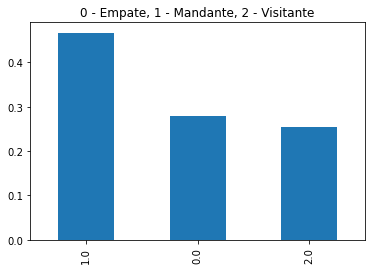

In [60]:
df2.resultado.value_counts(normalize=True).plot(kind='bar');
plt.title('0 - Empate, 1 - Mandante, 2 - Visitante');

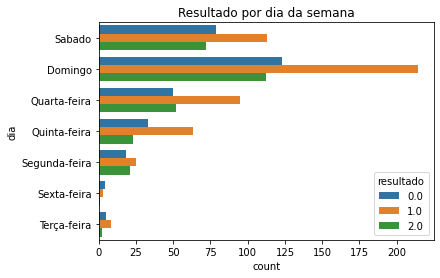

In [61]:
sns.countplot(y=df2.dia, hue=df2.resultado);
plt.title('Resultado por dia da semana');

# 3. Feature Engineering 

In [351]:
df3 = df2.copy()

In [352]:
to_drop = ['index','ID']
df3 = df3.drop(to_drop, axis = 1)

In [353]:
df3.head()

,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,...,visitante_precisao_passes,mandante_faltas,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,resultado
0,1,2019-04-27,16:02,Sabado,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,E. de Souza Barroca,E. de Souza Barroca,...,0.89,23.0,7.0,0.0,4.0,0.0,0.0,2.0,1.0,1.0
1,1,2019-04-27,19:00,Sabado,Atletico-MG,Avai,4-2-3-1,4-1-4-1,E. Machado Souto,E. Machado Souto,...,0.79,12.0,18.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,1,2019-04-27,19:01,Sabado,Chapecoense,Internacional,4-2-3-1,4-3-3,O. Hellmann,O. Hellmann,...,0.81,15.0,11.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0
3,1,2019-04-27,21:00,Sabado,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,L. Venker de Menezes,L. Venker de Menezes,...,0.79,13.0,17.0,4.0,4.0,0.0,1.0,0.0,1.0,1.0
4,1,2019-04-28,11:03,Domingo,Gremio,Santos,4-2-3-1,3-4-1-2,J. Sampaoli Moya,J. Sampaoli Moya,...,0.71,12.0,18.0,3.0,4.0,0.0,1.0,2.0,1.0,2.0


In [354]:
df3.dtypes

rodada                                int64
data                         datetime64[ns]
hora                                 object
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
tecnico_mandante                     object
tecnico_visitante                    object
arena                                object
mandante_placar                       int64
visitante_placar                      int64
mandante_estado                      object
visitante_estado                     object
estado_vencedor                      object
mandante_venceu_ultima                int64
visitante_venceu_ultima               int64
n_gols_mandante_ultima                int64
n_gols_visitante_ultima               int64
mandante_chutes                     float64
visitante_chutes                    float64
mandante_chutes_no_alvo         

In [355]:
df3.loc[:,'hora_decimal'] = pd.to_datetime(df3.hora).dt.hour + pd.to_datetime(df3.hora).dt.minute / 60

In [356]:
df3['hora_sin_'] = df3['hora_decimal'].apply(lambda x: np.sin(x * (2 * np.pi/24)))

In [357]:
df3 = df3.drop(['hora', 'hora_decimal'], axis = 1)

In [358]:
df3.insert(2, 'hora_sin', df3.hora_sin_)

In [359]:
df3 = df3.drop('hora_sin_', axis = 1)

In [360]:
df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,...,visitante_precisao_passes,mandante_faltas,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,resultado
0,1,2019-04-27,-0.870356,Sabado,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,E. de Souza Barroca,E. de Souza Barroca,...,0.89,23.0,7.0,0.0,4.0,0.0,0.0,2.0,1.0,1.0
1,1,2019-04-27,-0.965926,Sabado,Atletico-MG,Avai,4-2-3-1,4-1-4-1,E. Machado Souto,E. Machado Souto,...,0.79,12.0,18.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,1,2019-04-27,-0.964787,Sabado,Chapecoense,Internacional,4-2-3-1,4-3-3,O. Hellmann,O. Hellmann,...,0.81,15.0,11.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0
3,1,2019-04-27,-0.707107,Sabado,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,L. Venker de Menezes,L. Venker de Menezes,...,0.79,13.0,17.0,4.0,4.0,0.0,1.0,0.0,1.0,1.0
4,1,2019-04-28,0.246153,Domingo,Gremio,Santos,4-2-3-1,3-4-1-2,J. Sampaoli Moya,J. Sampaoli Moya,...,0.71,12.0,18.0,3.0,4.0,0.0,1.0,2.0,1.0,2.0


In [361]:
df3.dtypes

rodada                                int64
data                         datetime64[ns]
hora_sin                            float64
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
tecnico_mandante                     object
tecnico_visitante                    object
arena                                object
mandante_placar                       int64
visitante_placar                      int64
mandante_estado                      object
visitante_estado                     object
estado_vencedor                      object
mandante_venceu_ultima                int64
visitante_venceu_ultima               int64
n_gols_mandante_ultima                int64
n_gols_visitante_ultima               int64
mandante_chutes                     float64
visitante_chutes                    float64
mandante_chutes_no_alvo         

## 3.1 Features creation 

In [362]:
df3['ano'] = df3.data.dt.year
df3['dia_do_mes'] = df3.data.dt.day
df3['mes'] = df3.data.dt.month
df3['semana_do_ano'] = df3.data.dt.weekofyear

df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,...,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,resultado,ano,dia_do_mes,mes,semana_do_ano
0,1,2019-04-27,-0.870356,Sabado,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,E. de Souza Barroca,E. de Souza Barroca,...,4.0,0.0,0.0,2.0,1.0,1.0,2019,27,4,17
1,1,2019-04-27,-0.965926,Sabado,Atletico-MG,Avai,4-2-3-1,4-1-4-1,E. Machado Souto,E. Machado Souto,...,1.0,0.0,0.0,0.0,1.0,1.0,2019,27,4,17
2,1,2019-04-27,-0.964787,Sabado,Chapecoense,Internacional,4-2-3-1,4-3-3,O. Hellmann,O. Hellmann,...,1.0,0.0,0.0,0.0,2.0,1.0,2019,27,4,17
3,1,2019-04-27,-0.707107,Sabado,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,L. Venker de Menezes,L. Venker de Menezes,...,4.0,0.0,1.0,0.0,1.0,1.0,2019,27,4,17
4,1,2019-04-28,0.246153,Domingo,Gremio,Santos,4-2-3-1,3-4-1-2,J. Sampaoli Moya,J. Sampaoli Moya,...,4.0,0.0,1.0,2.0,1.0,2.0,2019,28,4,17


## 3.1 Data transformation 

In [363]:
# month
df3['mes_sin'] = df3['mes'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df3['mes_cos'] = df3['mes'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
# day
df3['dia_do_mes_sin'] = df3['dia_do_mes'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df3['dia_do_mes_cos'] = df3['dia_do_mes'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
# week of year
df3['semana_do_ano_sin'] = df3['semana_do_ano'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df3['semana_do_ano_cos'] = df3['semana_do_ano'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

In [364]:
df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,...,ano,dia_do_mes,mes,semana_do_ano,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos
0,1,2019-04-27,-0.870356,Sabado,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,E. de Souza Barroca,E. de Souza Barroca,...,2019,27,4,17,0.866025,-0.5,-0.587785,0.809017,0.885456,-0.464723
1,1,2019-04-27,-0.965926,Sabado,Atletico-MG,Avai,4-2-3-1,4-1-4-1,E. Machado Souto,E. Machado Souto,...,2019,27,4,17,0.866025,-0.5,-0.587785,0.809017,0.885456,-0.464723
2,1,2019-04-27,-0.964787,Sabado,Chapecoense,Internacional,4-2-3-1,4-3-3,O. Hellmann,O. Hellmann,...,2019,27,4,17,0.866025,-0.5,-0.587785,0.809017,0.885456,-0.464723
3,1,2019-04-27,-0.707107,Sabado,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,L. Venker de Menezes,L. Venker de Menezes,...,2019,27,4,17,0.866025,-0.5,-0.587785,0.809017,0.885456,-0.464723
4,1,2019-04-28,0.246153,Domingo,Gremio,Santos,4-2-3-1,3-4-1-2,J. Sampaoli Moya,J. Sampaoli Moya,...,2019,28,4,17,0.866025,-0.5,-0.406737,0.913545,0.885456,-0.464723


In [365]:
# rodadas
df3['rodadas_sin'] = df3['rodada'].apply(lambda x: np.sin(x * (2 * np.pi/38)))
df3['rodadas_cos'] = df3['rodada'].apply(lambda x: np.cos(x * (2 * np.pi/38)))

In [366]:
to_drop = ['dia', 'mes', 'ano', 'data', 'rodada', 'dia_do_mes', 'semana_do_ano']
df3 = df3.drop(to_drop, axis=1)

In [367]:
df3.insert(len(df3.columns.tolist()), 'resultado_final', df3.resultado)

In [368]:
df3 = df3.drop('resultado', axis = 1)

In [369]:
categorical = ['mandante', 'visitante', 'formacao_mandante', 'formacao_visitante', 'arena']
target = ['resultado_final']

df3_cat = df3[categorical]
df3_target = df3[target]

df3_vitoria = df3[['mandante_venceu_ultima', 'visitante_venceu_ultima']]

In [370]:
df3_cat_dummies = pd.get_dummies(df3_cat)

In [380]:
df3_cat_dummies.columns.tolist()

['mandante_America-MG',
 'mandante_Athletico-PR',
 'mandante_Atletico-GO',
 'mandante_Atletico-MG',
 'mandante_Avai',
 'mandante_Bahia',
 'mandante_Botafogo-RJ',
 'mandante_Bragantino',
 'mandante_CSA',
 'mandante_Ceara',
 'mandante_Chapecoense',
 'mandante_Corinthians',
 'mandante_Coritiba',
 'mandante_Cruzeiro',
 'mandante_Cuiaba',
 'mandante_Flamengo',
 'mandante_Fluminense',
 'mandante_Fortaleza',
 'mandante_Goias',
 'mandante_Gremio',
 'mandante_Internacional',
 'mandante_Juventude',
 'mandante_Palmeiras',
 'mandante_Santos',
 'mandante_Sao Paulo',
 'mandante_Sport',
 'mandante_Vasco',
 'visitante_America-MG',
 'visitante_Athletico-PR',
 'visitante_Atletico-GO',
 'visitante_Atletico-MG',
 'visitante_Avai',
 'visitante_Bahia',
 'visitante_Botafogo-RJ',
 'visitante_Bragantino',
 'visitante_CSA',
 'visitante_Ceara',
 'visitante_Chapecoense',
 'visitante_Corinthians',
 'visitante_Coritiba',
 'visitante_Cruzeiro',
 'visitante_Cuiaba',
 'visitante_Flamengo',
 'visitante_Fluminense',
 'v

In [372]:
categorical.append(target[0])

In [373]:
to_drop = ['mandante',
           'visitante',
           'formacao_mandante',
           'formacao_visitante',
           'tecnico_mandante', 
           'tecnico_visitante',
           'arena',
           'mandante_estado',
           'estado_vencedor',
           'visitante_estado',
           'mandante_venceu_ultima',
           'visitante_venceu_ultima',
           'resultado_final']

In [374]:
df3_numeric = df3.drop(to_drop, axis=1)

In [375]:
df3.head()

,hora_sin,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,arena,mandante_placar,visitante_placar,...,visitante_impedimentos,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos,resultado_final
0,-0.870356,Sao Paulo,Botafogo-RJ,4-2-3-1,4-1-4-1,E. de Souza Barroca,E. de Souza Barroca,morumbi,2,0,...,1.0,0.866025,-0.5,-0.587785,0.809017,0.885456,-0.464723,0.164595,0.986361,1.0
1,-0.965926,Atletico-MG,Avai,4-2-3-1,4-1-4-1,E. Machado Souto,E. Machado Souto,estadio raimundo sampaio,2,1,...,1.0,0.866025,-0.5,-0.587785,0.809017,0.885456,-0.464723,0.164595,0.986361,1.0
2,-0.964787,Chapecoense,Internacional,4-2-3-1,4-3-3,O. Hellmann,O. Hellmann,arena conda,2,0,...,2.0,0.866025,-0.5,-0.587785,0.809017,0.885456,-0.464723,0.164595,0.986361,1.0
3,-0.707107,Flamengo,Cruzeiro,4-2-3-1,4-2-3-1,L. Venker de Menezes,L. Venker de Menezes,maracana,3,1,...,1.0,0.866025,-0.5,-0.587785,0.809017,0.885456,-0.464723,0.164595,0.986361,1.0
4,0.246153,Gremio,Santos,4-2-3-1,3-4-1-2,J. Sampaoli Moya,J. Sampaoli Moya,arena do gremio,1,2,...,1.0,0.866025,-0.5,-0.406737,0.913545,0.885456,-0.464723,0.164595,0.986361,2.0


In [376]:
columns = df3_numeric.columns.tolist()

In [377]:
ss = StandardScaler()
df3_numeric_scaled = pd.DataFrame(ss.fit_transform(df3_numeric), columns=columns)

In [378]:
df3_numeric_scaled.head()

,hora_sin,mandante_placar,visitante_placar,n_gols_mandante_ultima,n_gols_visitante_ultima,mandante_chutes,visitante_chutes,mandante_chutes_no_alvo,visitante_chutes_no_alvo,mandante_posse_de_bola,...,mandante_impedimentos,visitante_impedimentos,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos
0,-0.202792,0.562091,-0.979600,-1.054064,-1.070022,-1.455842,-0.084266,-0.330471,-0.815287,-2.170772,...,0.423443,-0.280807,2.266602,-0.876216,-0.977710,1.180711,2.282713,-0.700326,0.229111,1.391262
1,-0.575607,0.562091,0.021530,-1.054064,-1.070022,-0.682902,-1.201145,-0.735308,-1.298485,0.775400,...,-1.072007,-0.280807,2.266602,-0.876216,-0.977710,1.180711,2.282713,-0.700326,0.229111,1.391262
2,-0.571165,0.562091,-0.979600,-1.054064,-1.070022,-0.489667,1.926116,0.884038,1.600699,-0.789754,...,-1.072007,0.506581,2.266602,-0.876216,-0.977710,1.180711,2.282713,-0.700326,0.229111,1.391262
3,0.434035,1.443120,0.021530,-1.054064,-1.070022,0.476508,-2.094649,0.074365,-1.298485,0.591264,...,-1.072007,-0.280807,2.266602,-0.876216,-0.977710,1.180711,2.282713,-0.700326,0.229111,1.391262
4,4.152659,-0.318939,1.022659,-1.054064,-1.070022,2.215623,-0.754394,2.503383,0.634305,1.235739,...,0.423443,-0.280807,2.266602,-0.876216,-0.717075,1.327360,2.282713,-0.700326,0.229111,1.391262


In [394]:
df3_final = pd.concat([df3_cat_dummies, df3_vitoria, df3_numeric_scaled, df3_target], axis = 1)

min_columns = [
               'hora_sin',
               'mandante_placar',
               'visitante_placar',
               'mandante_chutes_no_alvo',
               'visitante_chutes_no_alvo',
               'mandante_passes',
               'visitante_passes',
               'mandante_precisao_passes',
               'visitante_precisao_passes',
               'mandante_faltas',
               'visitante_faltas',
               'mandante_cartao_amarelo',
               'visitante_cartao_amarelo',
               'mandante_cartao_vermelho',
               'visitante_cartao_vermelho',
               'mandante_impedimentos',
               'visitante_impedimentos',
               'mes_sin',
               'mes_cos',
               'dia_do_mes_sin',
               'dia_do_mes_cos',
               'semana_do_ano_sin',
               'semana_do_ano_cos',
               'rodadas_sin',
               'rodadas_cos',
               ]

df3_final = df3_final.drop(min_columns, axis = 1)

In [395]:
# Function to calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

X=df3_final.drop(['resultado_final'],axis=1)
calculate_vif(X)

,Var,Vif
0,mandante_America-MG,inf
83,formacao_visitante_4-2-2-2,inf
97,arena_arena barueri,inf
96,arena_allianz parque,inf
95,arena_alfredo jaconi,inf
...,...,...
130,mandante_venceu_ultima,1.81
133,n_gols_visitante_ultima,1.81
131,visitante_venceu_ultima,1.75
135,visitante_chutes,1.57


# 4.0 Feature selection and scaling 

In [396]:
df4 = df3_final.copy()

In [397]:
df4 = df4.dropna()

In [398]:
df4.shape

(1116, 139)

In [399]:
X = df4.drop(['resultado_final'], axis=1)
y = df4.resultado_final

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False)

In [401]:
undersampling = RandomOverSampler(random_state=32)

In [402]:
X_train, y_train = undersampling.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='resultado_final', ylabel='count'>

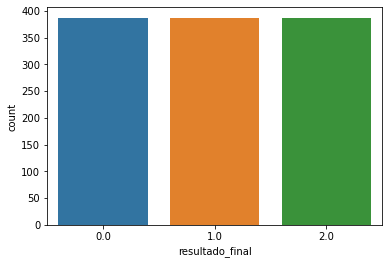

In [403]:
sns.countplot(y_train)

# 5.0 Machine Learning Models 

## 5.1 Logistic Regression 

In [404]:
clf_lg = LogisticRegression().fit(X_train, y_train)
y_hat_lg = clf_lg.predict(X_test)

In [405]:
accuracy_score(y_test, y_hat_lg)

0.4767025089605735

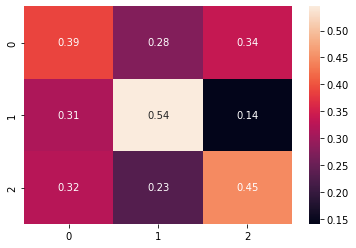

In [406]:
sns.heatmap(confusion_matrix(y_test, y_hat_lg, normalize='true'), annot=True);

In [407]:
print(classification_report(y_test, y_hat_lg))

              precision    recall  f1-score   support

         0.0       0.33      0.39      0.36        80
         1.0       0.66      0.54      0.60       134
         2.0       0.39      0.45      0.41        65

    accuracy                           0.48       279
   macro avg       0.46      0.46      0.46       279
weighted avg       0.50      0.48      0.49       279



## 5.2 XGBoost 

In [408]:
clf_xgb = xgb.XGBRFClassifier(n_estimators = 1000).fit(X_train, y_train)
yhat_xgb = clf_xgb.predict(X_test)

[13:42:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [409]:
accuracy_score(y_test, yhat_xgb)

0.43727598566308246

<AxesSubplot:>

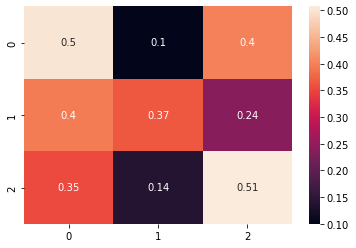

In [410]:
sns.heatmap(confusion_matrix(y_test, yhat_xgb, normalize='true'), annot=True, )

In [411]:
print(classification_report(y_test, yhat_xgb))

              precision    recall  f1-score   support

         0.0       0.34      0.50      0.41        80
         1.0       0.74      0.37      0.49       134
         2.0       0.34      0.51      0.41        65

    accuracy                           0.44       279
   macro avg       0.48      0.46      0.44       279
weighted avg       0.53      0.44      0.45       279



## 5.3 Random Forests

In [412]:
clf_rf = RandomForestClassifier(n_estimators = 2000, n_jobs = -1, random_state = 42).fit(X_train, y_train)
yhat_rf = clf_rf.predict(X_test)

In [413]:
accuracy_score(y_test, yhat_rf)

0.5125448028673835

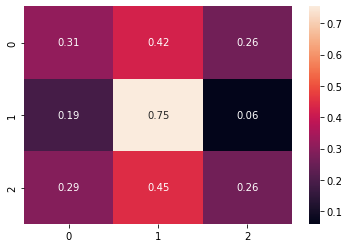

In [414]:
sns.heatmap(confusion_matrix(y_test, yhat_rf, normalize='true'), annot=True, );

In [415]:
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

         0.0       0.36      0.31      0.34        80
         1.0       0.62      0.75      0.68       134
         2.0       0.37      0.26      0.31        65

    accuracy                           0.51       279
   macro avg       0.45      0.44      0.44       279
weighted avg       0.49      0.51      0.49       279



## 5.4 SVM 

In [416]:
clf_svc = svm.SVC().fit(X_train, y_train)
y_hat_svc = clf_svc.predict(X_test)

In [417]:
accuracy_score(y_test, y_hat_svc)

0.5161290322580645

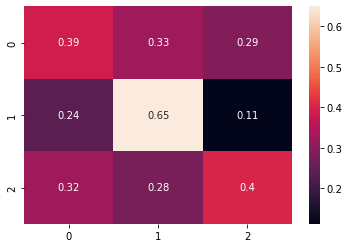

In [418]:
sns.heatmap(confusion_matrix(y_test, y_hat_svc, normalize='true'), annot=True);

In [419]:
print(classification_report(y_test, y_hat_svc))

              precision    recall  f1-score   support

         0.0       0.37      0.39      0.38        80
         1.0       0.66      0.65      0.66       134
         2.0       0.41      0.40      0.40        65

    accuracy                           0.52       279
   macro avg       0.48      0.48      0.48       279
weighted avg       0.52      0.52      0.52       279



## 5.5 Naive Bayes 

In [420]:
clf_gb = GaussianNB().fit(X_train, y_train)
y_hat_gnb = clf_gb.predict(X_test)

In [421]:
accuracy_score(y_test, y_hat_gnb)

0.2939068100358423

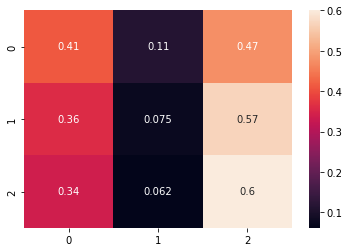

In [422]:
sns.heatmap(confusion_matrix(y_test, y_hat_gnb, normalize='true'), annot=True, );

In [423]:
print(classification_report(y_test, y_hat_gnb))

              precision    recall  f1-score   support

         0.0       0.32      0.41      0.36        80
         1.0       0.43      0.07      0.13       134
         2.0       0.25      0.60      0.36        65

    accuracy                           0.29       279
   macro avg       0.34      0.36      0.28       279
weighted avg       0.36      0.29      0.25       279



## 5.6 SGD Classifier 

In [424]:
clf_sgd = SGDClassifier().fit(X_train, y_train)
y_hat_sgd = clf_sgd.predict(X_test)

In [425]:
accuracy_score(y_test, y_hat_sgd)

0.4731182795698925

<AxesSubplot:>

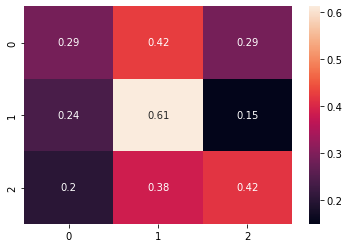

In [426]:
sns.heatmap(confusion_matrix(y_test, y_hat_sgd, normalize='true'), annot=True, )

In [427]:
print(classification_report(y_test, y_hat_sgd))

              precision    recall  f1-score   support

         0.0       0.34      0.29      0.31        80
         1.0       0.58      0.61      0.60       134
         2.0       0.39      0.42      0.40        65

    accuracy                           0.47       279
   macro avg       0.44      0.44      0.44       279
weighted avg       0.47      0.47      0.47       279



## 5.7 Decision Tree

In [428]:
clf_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_hat_dt = clf_dt.predict(X_test)

In [429]:
accuracy_score(y_test, y_hat_dt)

0.43010752688172044

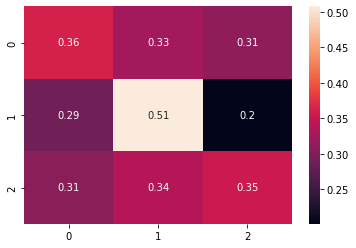

In [430]:
sns.heatmap(confusion_matrix(y_test, y_hat_dt, normalize='true'), annot=True, );

In [431]:
print(classification_report(y_test, y_hat_dt))

              precision    recall  f1-score   support

         0.0       0.33      0.36      0.35        80
         1.0       0.59      0.51      0.54       134
         2.0       0.31      0.35      0.33        65

    accuracy                           0.43       279
   macro avg       0.41      0.41      0.41       279
weighted avg       0.45      0.43      0.44       279



## 5.8 MLP

In [432]:
clf_mlp = MLPClassifier(max_iter=500).fit(X_train, y_train)
y_hat_mlp = clf_mlp.predict(X_test)

In [433]:
accuracy_score(y_test, y_hat_mlp)

0.46236559139784944

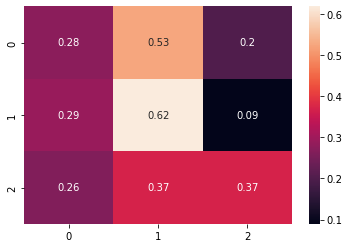

In [434]:
sns.heatmap(confusion_matrix(y_test, y_hat_mlp, normalize='true'), annot=True, );

In [276]:
print(classification_report(y_test, y_hat_mlp))

              precision    recall  f1-score   support

         0.0       0.31      0.23      0.26        80
         1.0       0.60      0.57      0.59       134
         2.0       0.34      0.48      0.40        65

    accuracy                           0.45       279
   macro avg       0.41      0.43      0.41       279
weighted avg       0.45      0.45      0.45       279



# 6.0 Ensemble 

In [277]:
import warnings
warnings.filterwarnings("ignore")

In [278]:
eclf = VotingClassifier(estimators=[('logistic', clf_lg), ('xgb', clf_xgb), ('random_forest', clf_rf), ('naive_bayes', clf_gb), ('decision_tree', clf_dt), ('mlp', clf_mlp)], voting='hard')

In [279]:
for clf, label in zip([clf_lg, clf_xgb, clf_rf, clf_gb, clf_dt], ['logistic', 'xgb', 'random_forest', 'naive_bayes', 'decision_tree', 'mlp' ]):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.50 (+/- 0.01) [logistic]
[11:44:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_m

In [472]:
eclf = VotingClassifier(estimators=[('svc', clf_svc), ('nb', clf_gb), ('sgd', clf_sgd)], voting='hard').fit(X_train, y_train)

In [473]:
y_hat_eclf = eclf.predict(X_test)

In [474]:
accuracy_score(y_test, y_hat_eclf)

0.45878136200716846

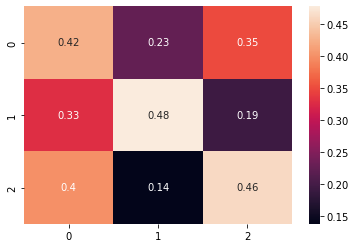

In [475]:
sns.heatmap(confusion_matrix(y_test, y_hat_eclf, normalize='true'), annot=True, );

In [467]:
print(classification_report(y_test, y_hat_eclf))

              precision    recall  f1-score   support

         0.0       0.38      0.46      0.42        80
         1.0       0.66      0.55      0.60       134
         2.0       0.38      0.40      0.39        65

    accuracy                           0.49       279
   macro avg       0.47      0.47      0.47       279
weighted avg       0.51      0.49      0.50       279

